In [1]:
import numpy as np
import matplotlib.pyplot as plt
import robotteknikk as rob
import cmath 


""" 
Test array, to compare with Corke
R = np.array([[0.9021, -0.3836, 0.1977],
              [0.3875, 0.9216, 0.0198],
              [-0.1898, 0.0587, 0.9801]])
"""
def isR(R):
    Rdim = R.shape
    RtR = R.T.dot(R)
    tol = 1e-5
    detR = np.linalg.det(R)
    
    #checks if RtR and detR is close to the identity matrix and 1.
    if np.allclose(RtR,np.eye(Rdim[0]), rtol=tol, atol=tol) and np.isclose(detR,1,rtol=tol, atol=tol):
        
        print("det(R) = ",detR,"\n")
        print("R^TR = \n",RtR.round(3))
        print("\nR =\n",R,"\n\nIs a valid rotation matrix\n")
    else:
       
        print("det(R) = ",detR,"\n")
        print("R^TR = \n",RtR.round(3))
        print("\nR =\n", R,"\n\nIs NOT avalid rotation matrix\n")



def rotx(theta):
    """ 
    3D rotation matrix along x axis 
    """
    return np.array([[1,0,0],
                     [0,np.cos(theta),-np.sin(theta)],
                     [0,np.sin(theta),np.cos(theta)]])

def roty(theta):
    """ 
    3D rotation matrix along y axis 
    theta is angle in radians
    """
    return np.array([[np.cos(theta),0,np.sin(theta)],
                     [0,1,0],
                     [-np.sin(theta),0, np.cos(theta)]])    
    
def rotz(theta):
    """ 
    3D rotation matrix along z axis
    theta is angle in radians
    """
    return np.array([[np.cos(theta),-np.sin(theta),0],
                     [np.sin(theta),np.cos(theta),0],
                     [0,0,1]])
    

def rpy2r(roll,pitch,yaw):
    """ 3D Rotation matrix from roll, pitch, yaw
        roll, pitch, yaw are in radians
    """
    R = rotx(roll).dot(roty(pitch)).dot(rotz(yaw))
    return R


def tpr(R):
    """ 
    This function returns a homogeneous pure rotation matrix 
    """
    
    n = R.shape[0] # finds shape of first column, either 2 or 3.
    
    if n == 2:
        # Creates a identity matrix of 3 dimensions
        T = np.eye(3)
        # Append the identity matrix rows and columns with R input
        T[0:2,0:2] = R
        
    elif n == 3:
        # Creates a identity matrix of 4 dimensions
        T = np.eye(4)
        # Append the identity matrix rows and columns with R input
        T[0:3,0:3] = R
        
    else:
        print("Invalid rotation matrix. Please check that dimensions are correct")
        
    return T 

def r2quat(R, print=None):
    """ 
    This function converts the rotation matrix to
    its equvivalent unit quaternion expression
    
    A Quaternion is a hyper complex number:
            a + ib + jc + ke
    
    Represented as:
            q = s + v(i,j,k)
    
    Where s is the real part and v is the imaginary part
    """
    s = (1/2)*np.sqrt(1+R[0,0]+R[1,1]+R[2,2])
    q = np.array([[R[2,1]-R[1,2]],
                  [R[0,2]-R[2,0]],
                  [R[1,0]-R[0,1]]])
    v = (1/(4*s))*q
    
    if print is not None:
        print(f"{s} <{v.T}>")
    return s, v

def r2angvec(R):
    """ 
    This function converts a rotation matrix to the equivalent
    vector-angle representation
    """
    # Finds the eigen values and vectors of R
    eigvalues, eigvectors = np.linalg.eig(R)
    
    # Creates 3 arrays with only the value of imaginart parts
    v0 = np.imag(eigvectors[:,0])
    v1 = np.imag(eigvectors[:,1])
    v2 = np.imag(eigvectors[:,2])
    
    # Creates an array of zeroes in the same dimension
    zeros = np.zeros(eigvectors.shape[0])
    
    # Finds vector with zero imaginart parts. 
    # This is the vector we want to return
    if (v0 == zeros).all():
        vector = np.real(eigvectors[:,0])
    elif (v1 == zeros).all():
        vector = np.real(eigvectors[:,1])
    elif (v2 == zeros).all():
        vector = np.real(eigvectors[:,2])
    else:
        print("No column with only real parts")
    v.shape = 3,1
    
    # Finds the index of first positive angle from eigenvalues array
    i = 0
    while np.angle(eigvalues[i]) <= 0:
        i = i+1
    angle = np.angle(eigvalues[i])
    
    return angle, vector

def skew(v):
    """
    Returns a skew symmetric matric from a vector
    w with dimensions 3x1
    """
    vx = v[0]
    vy = v[1]
    vz = v[2]
    
    skew = np.array([
                    [0,-vz,vy],
                    [vz,0,-vx],
                    [-vy,vx,0]
                    ])   
    return skew

def angvec2r(theta, v):
    """
    This function computes a rotational matrix from 
    the angle vector.
    
    Theta is in radians and vector is of dimensions 3x1
    
    Using the Rodrigues formula:
        R = I_{3X3} + sin(theta) S(vector) + (1 - cos(theta))(vv.T - I_{3X3})
    Where S is the skew matrix
    """
    n = v.shape[0] # Defines the shape of vector array
    I = np.eye(n) # Creates an identity matrix of n-size
    
    s = np.sqrt(v[0]**2+v[1]**2+v[2]**2) # Computes the length of v 
    # Can also use s = np.sqrt(v.dot(v))
    v = v/s # Renormalize v, it now has unit length
    S = skew(v) # Returns the skew matrix made form vector array
    
    # Computes the rotational matrix by using Rodrigues formula
    R = I + np.sin(theta) * S + (1 - np.cos(theta))*(np.outer(v,v) - I)
    return R

def plotR(R):
    # To plot the rotational matrix it must be converted to the homogeneous pure rotation matrix
    T = tpr(R)

    # Define the plot and use robotteknikk's plotting function
    fig = plt.figure(1, figsize=(10,10))
    ax = plt.axes(projection='3d')
    rob.trplot3(ax,T,name="0")

array([[ 0.   ,  0.866,  0.5  ,  0.   ],
       [-0.707,  0.354, -0.612,  0.   ],
       [-0.707, -0.354,  0.612,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  1.   ]])

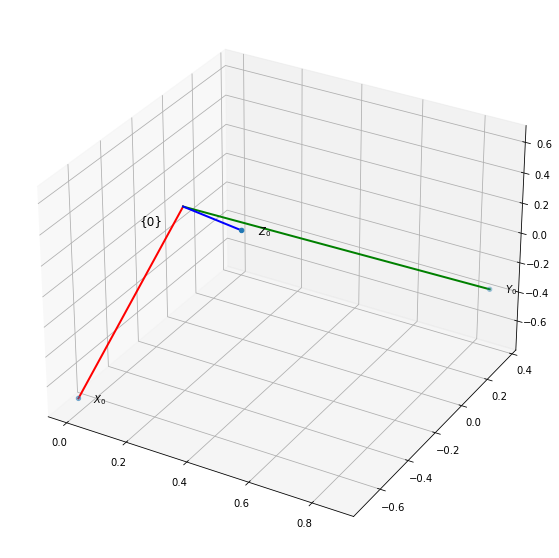

In [2]:
# Define the roll, pitch and yaw angles
roll = (np.pi)/4
pitch = (np.pi)/6
yaw = -(np.pi)/2

# Create a rotation matrix based on rpy
R = rpy2r(roll, pitch, yaw)

# To plot the rotational matrix it must be converted to the homogeneous pure rotation matrix
T = tpr(R)

# Define the plot and use robotteknikk's plotting function
fig = plt.figure(1, figsize=(10,10))
ax = plt.axes(projection='3d')
rob.trplot3(ax,T,name="0")
T.round(3)

In [21]:
# Exercise 7.b
def r2quat(R, print=None):
    """ 
    This function converts the rotation matrix to
    its equvivalent unit quaternion expression
    
    A Quaternion is a hyper complex number:
            a + ib + jc + ke
    
    Represented as:
            q = s + v(i,j,k)
    
    Where s is the real part and v is the imaginary part
    """
    s = (1/2)*np.sqrt(1+R[0,0]+R[1,1]+R[2,2])
    q = np.array([[R[2,1]-R[1,2]],
                  [R[0,2]-R[2,0]],
                  [R[1,0]-R[0,1]]])
    v = (1/(4*s))*q
    
    if print is not None:
        print(f"{s} <{v.T}>")
    return s, v

s, v = r2quat(R, print)

0.7010573846499779 <[[ 0.09229596  0.43045933 -0.56098553]]>


In [28]:
# Exercise 7.c

def r2angvec(R):
    """ 
    This function converts a rotation matrix to the equivalent
    vector-angle representation
    """
    # Finds the eigen values and vectors of R
    eigvalues, eigvectors = np.linalg.eig(R)
    
    # Exstract imaginart parts from eigenvectors
    v0 = np.imag(eigvectors[:,0])
    v1 = np.imag(eigvectors[:,1])
    v2 = np.imag(eigvectors[:,2])
    
    # Creates an array of zeroes in the same dimension
    zeros = np.zeros(eigvectors.shape[0])
    
    # Identifies the vector with no imaginart parts. 
    if (v0 == zeros).all():
        vector = np.real(eigvectors[:,0])
    elif (v1 == zeros).all():
        vector = np.real(eigvectors[:,1])
    elif (v2 == zeros).all():
        vector = np.real(eigvectors[:,2])
    else:
        print("No column with only real parts")
    
    # Identifies index of theta 
    i = 0
    while np.angle(eigvalues[i]) <= 0:
        i = i+1
    
    angle = np.angle(eigvalues[i])
    
    return angle, vector

theta, v = r2angvec(R)

np.degrees(theta), v

(35.99999999999999, array([-7.07106781e-01,  7.07106781e-01, -2.31439426e-16]))

array([[ 0.905, -0.095,  0.416],
       [-0.095,  0.905,  0.416],
       [-0.416, -0.416,  0.809]])

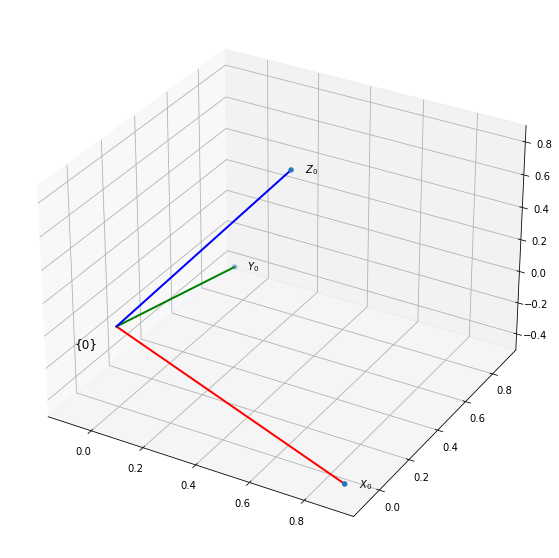

In [25]:
# Exercise 8.a

def skew(v):
    """
    Returns a skew symmetric matric from a vector
    w with dimensions 3x1
    """
    vx = v[0]
    vy = v[1]
    vz = v[2]
    skew = np.array([[0,-vz,vy],
                     [vz,0,-vx],
                     [-vy,vx,0]])   
    return skew

def angvec2r(theta, v):
    """
    This function computes a rotational matrix from 
    the angle vector.
    
    Theta is in radians and vector is of dimensions 3x1
    
    Using the Rodrigues formula:
        R = I_{3X3} + sin(theta) S(vector) + (1 - cos(theta))(vv.T - I_{3X3})
    Where S is the skew matrix
    """
    n = v.shape[0] # Defines the shape of vector array
    I = np.eye(n) # Creates an identity matrix of n-size
    
    s = np.sqrt(v[0]**2+v[1]**2+v[2]**2) # Computes the length of v 
    # Can also use s = np.sqrt(v.dot(v))
    v = v/s # Renormalize v, it now has unit length
    S = skew(v) # Returns the skew matrix made form vector array
    
    # Computes the rotational matrix by using Rodrigues formula
    R = I + np.sin(theta) * S + (1 - np.cos(theta))*(np.outer(v,v) - I)
    return R
    
def plotR(R):
    # To plot the rotational matrix it must be converted to the homogeneous pure rotation matrix
    T = tpr(R)
    
    # Define the plot and use robotteknikk's plotting function
    fig = plt.figure(1, figsize=(10,10))
    ax = plt.axes(projection='3d')
    rob.trplot3(ax,T,name="0")
    
theta = np.pi/5
v = np.array([-np.sqrt(2)/2, np.sqrt(2)/2,0])

R = angvec2r(theta, v)
plotR(R)
R.round(3)

In [26]:
R.round(3)

array([[ 0.905, -0.095,  0.416],
       [-0.095,  0.905,  0.416],
       [-0.416, -0.416,  0.809]])

In [27]:
# Exercise 8.b

def r2quat(R, print=None):
    """ 
    This function converts the rotation matrix to
    its equvivalent unit quaternion expression
    
    A Quaternion is a hyper complex number:
            a + ib + jc + ke
    
    Represented as:
            q = s + v(i,j,k)
    
    Where s is the real part and v is the imaginary part
    """
    s = 1/2*np.sqrt(1+R[0,0]+R[1,1]+R[2,2])
    q = np.array([[R[2,1]-R[1,2]],
                  [R[0,2]-R[2,0]],
                  [R[1,0]-R[0,1]]])
    v = 1/(4*s) * q
    
    if print is not None:
        print(f"{s} <{v.T}>")
    return s, v

s, v = r2quat(R, print)

0.9510565162951535 <[[-0.21850801  0.21850801  0.        ]]>


In [6]:
rotz(np.pi).round(3)

array([[-1., -0.,  0.],
       [ 0., -1.,  0.],
       [ 0.,  0.,  1.]])

In [8]:
rotx(-np.pi/2).round(3)

array([[ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0., -1.,  0.]])

In [4]:
T.round(3)

array([[-1., -0., -0.],
       [ 0., -0., -1.],
       [ 0., -1.,  0.]])